In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision

from tqdm import tqdm
import random

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

from utils import set_random_seed
set_random_seed(seed=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, latent_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 784)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        z = F.tanh(self.fc1(z))
        z = F.tanh(self.fc2(z))
        return z


class SimpleAE(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(SimpleAE, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        o = self.decoder(z)
        return o
    
    def loss_fn(self, x: torch.Tensor, x_hat: torch.Tensor) -> float:
        mse = torch.mean((x - x_hat)**2) # by pixel
        return mse
    
    def reg_weights_loss_fn(self, lam: float) -> float:
        learnable_weights = [p for p in self.parameters() if p.requires_grad and p.dim() > 1]
        loss = lam * torch.sum(torch.tensor([torch.sum(w**2) for w in learnable_weights]))
        return loss
    
    def reg_clarity_loss_fn(self, lam: float, x_hat: torch.Tensor) -> float:
        # penalize pixels close to 0
        # to make generated image more contrast
        clear_loss = lam * torch.mean((1 + x_hat) * (1 - x_hat)) # by pixel
        return clear_loss


In [10]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,)) # (x/255 - 0.5) / 0.5
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=128, shuffle=True, drop_last=True)

for x, _ in tqdm(dataloader):
    print(x.size())
    break

  0%|          | 0/468 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28])


In [5]:
epochs = 5
latent_dim = 16

device = 'cuda' if torch.cuda.is_available() else 'cpu'
autoencoder = SimpleAE(latent_dim).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

for epoch in range(epochs):
    for batch, (x, _) in enumerate(dataloader):
        
        x = torch.flatten(x, start_dim=1, end_dim=-1) # [B, 1, 784]
        x = x.to(device)
        x_hat = autoencoder(x) # [B, 1, 784]

        loss = autoencoder.loss_fn(x, x_hat)
        reg_weights_loss = autoencoder.reg_weights_loss_fn(lam=1e-5)
        reg_clarity_loss = autoencoder.reg_clarity_loss_fn(x_hat=x_hat, lam=5e-1)
        total_loss = loss + reg_weights_loss + reg_clarity_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            print(
                f"epoch = {epoch}",
                f"batch = {batch:03d}", 
                f"MSE: {loss.item():.4f}", 
                f"REG WEIGHTS: {reg_weights_loss.item():.4f}", 
                f"REG CLARITY: {reg_clarity_loss.item():.4f}",
                f"total loss: {total_loss.item():.4f}"
            )

    print()

epoch = 0 batch = 000 MSE: 0.9579 REG WEIGHTS: 0.0035 REG CLARITY: 0.4932 total loss: 1.4546
epoch = 0 batch = 100 MSE: 0.2858 REG WEIGHTS: 0.0045 REG CLARITY: 0.0996 total loss: 0.3899
epoch = 0 batch = 200 MSE: 0.2726 REG WEIGHTS: 0.0053 REG CLARITY: 0.0905 total loss: 0.3685
epoch = 0 batch = 300 MSE: 0.2788 REG WEIGHTS: 0.0060 REG CLARITY: 0.0719 total loss: 0.3567
epoch = 0 batch = 400 MSE: 0.2539 REG WEIGHTS: 0.0067 REG CLARITY: 0.0750 total loss: 0.3356

epoch = 1 batch = 000 MSE: 0.2377 REG WEIGHTS: 0.0074 REG CLARITY: 0.0684 total loss: 0.3136
epoch = 1 batch = 100 MSE: 0.2294 REG WEIGHTS: 0.0083 REG CLARITY: 0.0635 total loss: 0.3012
epoch = 1 batch = 200 MSE: 0.2149 REG WEIGHTS: 0.0091 REG CLARITY: 0.0589 total loss: 0.2829
epoch = 1 batch = 300 MSE: 0.2255 REG WEIGHTS: 0.0099 REG CLARITY: 0.0592 total loss: 0.2947
epoch = 1 batch = 400 MSE: 0.1930 REG WEIGHTS: 0.0109 REG CLARITY: 0.0594 total loss: 0.2632

epoch = 2 batch = 000 MSE: 0.1971 REG WEIGHTS: 0.0115 REG CLARITY: 0

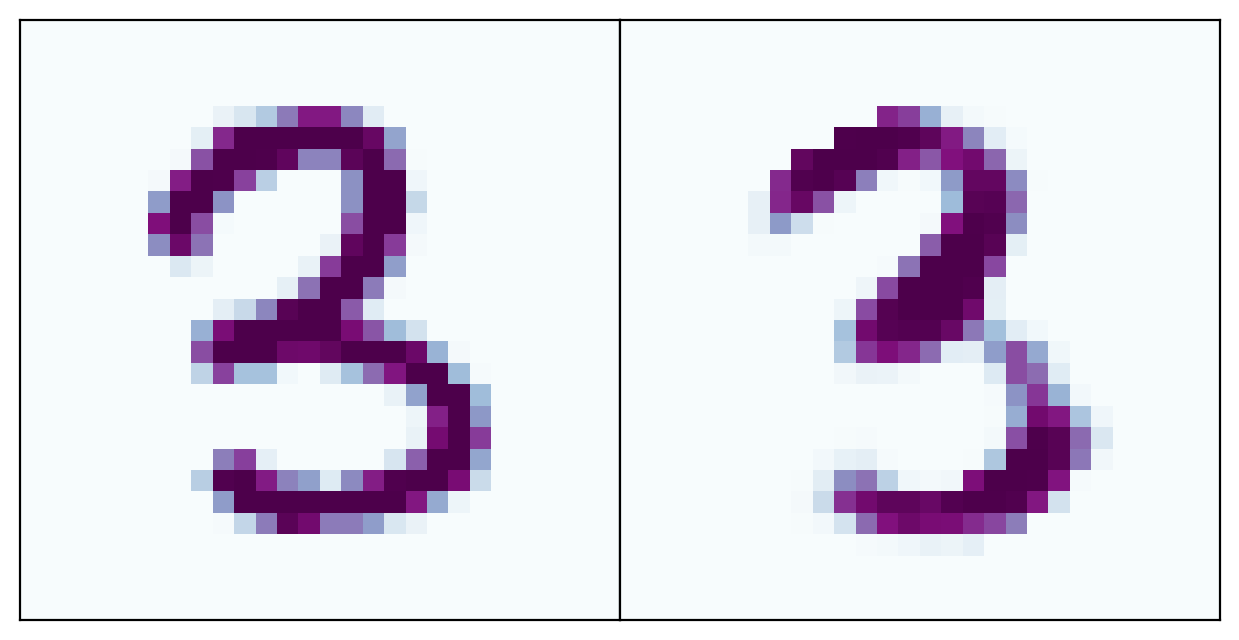

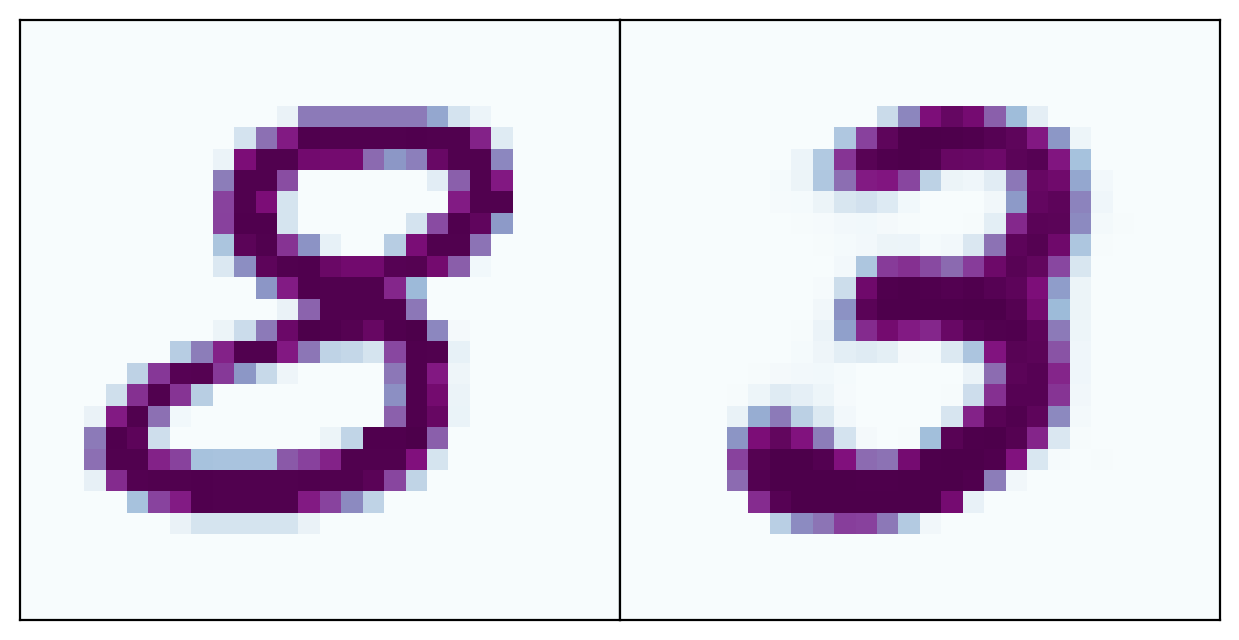

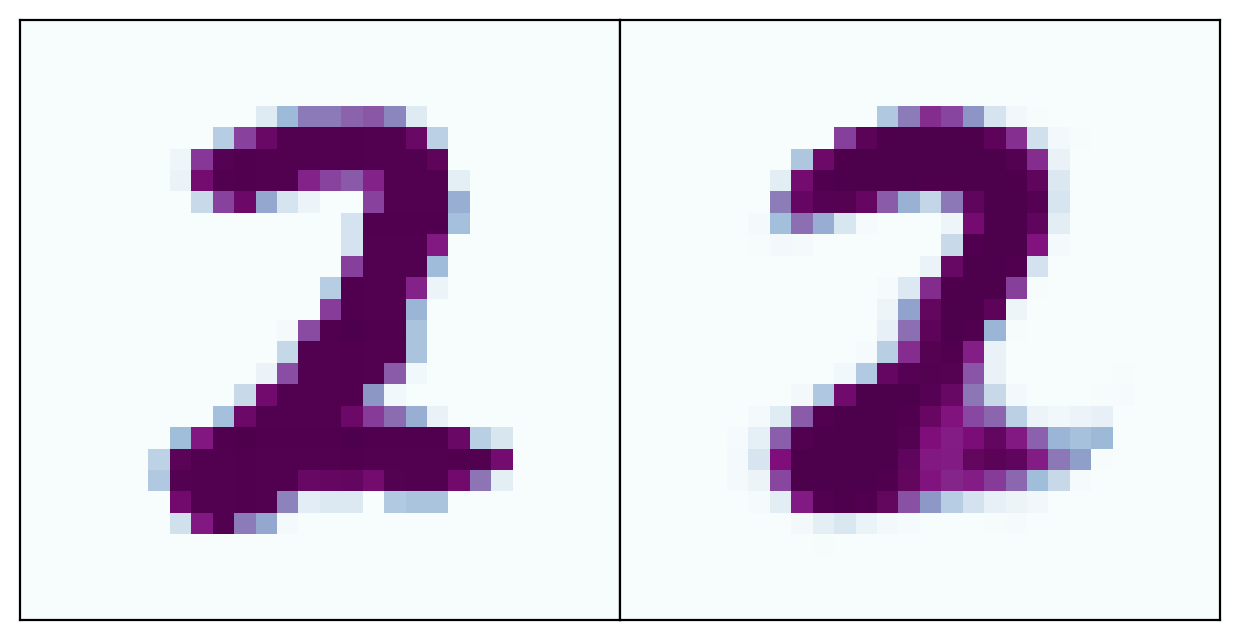

In [7]:
set_random_seed(seed=0)
imgs = [dataset[r] for r in random.sample(range(30_000), 3)]

for img, label in imgs:
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(img.view(28,28), cmap='BuPu');

    img_hat = autoencoder(img.view(1,1,784).to(device))
    ax2.imshow(img_hat.view(28,28).cpu().detach(), cmap='BuPu');
    ax2.set_xticks([])
    ax2.set_yticks([])

    plt.show()